# Safari

**Setting up the environment**
Initialization of the Ontology editor in Jupyter Notebook

In [1]:
from cognipy.ontology import Ontology #the ontology processing class
from cognipy.ontology import CQL #SPARQL format tailored for Contolled Natural Language
from cognipy.edit import CnlEditBox #The pywidget based ontology editor (offspirng of the Fluent Editor)
from cognipy.edit import CnlQueryForConcept #The pywidget based ontology quaty widget 
from cognipy.ontology import encode_string_for_graph_label #complex datatypes encoder for the graph labels in graph visualisation
import textwrap

def graph_attribute_formatter(val):
    if isinstance(val,list) or isinstance(val,set):
        return " | ".join(list(map(lambda i:encode_string_for_graph_label(graph_attribute_formatter(i)),val)))
    elif isinstance(val,dict):
        return " | ".join(list(map(lambda i:i[0]+" : "+encode_string_for_graph_label(graph_attribute_formatter(i[1])),val.items())))
    else:
        return encode_string_for_graph_label(textwrap.fill(str(val),40))

### African Wildlife.
Loading the editor for the basic "safari" ontology. The Ontology is inspired by 'A Semantic Web Primer.' by 'Antoniou, G, van Harmelen, F.' 'MIT Press, 2003.' 'http://www.csd.uoc.gr/~hy566/SWbook.pdf', tuned to OWL/RL+SWRL profile.

### Part-1: 'simple hierarchy of beings'. 

We will have many editors here and we will store all of them in the dict

In [2]:
parts_editors={}

Lets setup the fist ontology editor for the general knowledge. The editor allows you to enter the knowledge in text format, and support you with the prdictive editor.

In [3]:
parts_editors['01']=CnlEditBox('part_01.encnl')
parts_editors['01']

<IPython.core.display.Javascript object>

Lets define the function that will build the ontology based on the dict of ontology editors and the optional additional editor for testing purposes. All it is doing it is concatenaiting the values of all the editors and puts them into the newly created ontology object.

In [4]:
def buildOntology(parts_editors,test_editor=None):
    return Ontology("cnl/string",
                    "\n\n".join(k.getvalue() for k in parts_editors.values())+('' if test_editor is None else test_editor.getvalue()), 
                    evaluator = lambda e:eval(e,globals(),locals()), 
                    graph_attribute_formatter = graph_attribute_formatter)

The ontology object alows you to draw the materialised graph using several layout algorythms. Lets draw our base ontology.

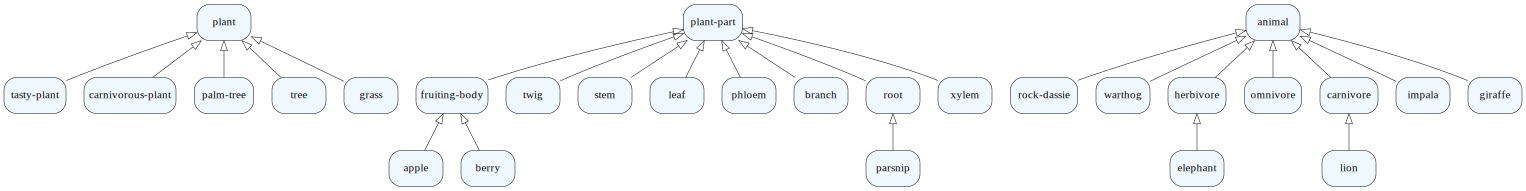

In [5]:
onto=buildOntology(parts_editors)
onto.draw_graph(layout='hierarchical')

It is fully compatible with OWL/RDF format (via OWLAPI). We can always export it as it is.

### Part-2: Disjointness
In OWL/RL+SWRL profile we deal with Open World Assumption. It means that we need to explicitly specify all the objects that are different from each other. We cannot assume (like e.g. object oriented programming language do) that the different names mean the different things, therefore we need to specify explicitly if two things are different.

In [6]:
parts_editors['02']=CnlEditBox('part_02.encnl',onto)
parts_editors['02']

Lets test how it works on the example. The example will be defining several instances, that aim to break the consistency of the ontology in som not obvious way.

In [7]:
test_01_edit = CnlEditBox('test_01.encnl',onto)
test_01_edit

Lets load all the parts ontology ontology togheter with the testing part into the newly created obeject. 

In [8]:
onto=buildOntology(parts_editors,test_01_edit)

We will need also some way to describe what is wrong `printReasoningInfo` and why `printWhy`.

In [9]:
import json

def printReasoningInfo(onto):
    info=onto.reasoningInfo()
    if info == "":
        print('all good!')
    else:
        print(json.dumps(json.loads(info), indent=2, sort_keys=True))

def printWhy(onto,fact):
    info=json.loads(onto.why(fact))
    print(json.dumps(info, indent=2, sort_keys=True))

So what is wrong here?

In [10]:
printReasoningInfo(onto)

{
  "errors": [
    {
      "content": "Complement classes",
      "title": "inconsistency",
      "vals": {
        "concept": "animal",
        "instance": "Mary-01"
      }
    }
  ]
}


Lets draw it on a diagram, this time using force directed layout.

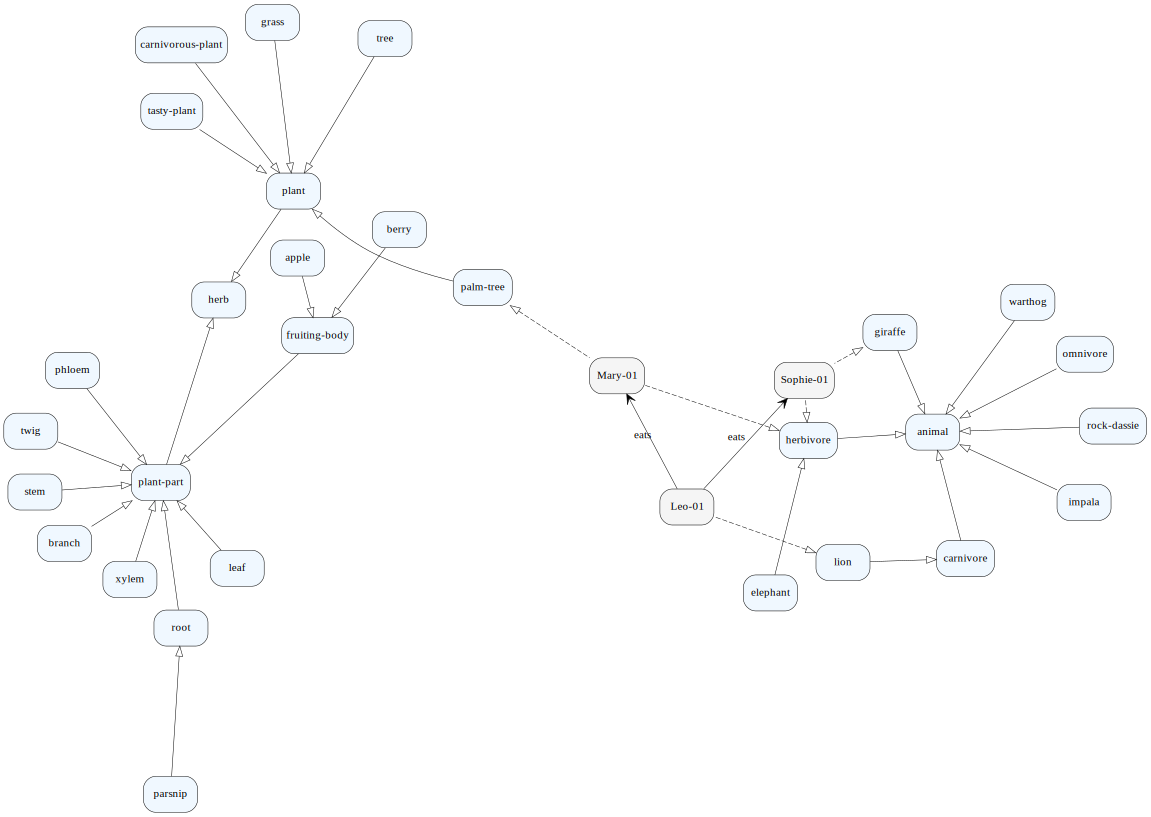

In [11]:
onto.draw_graph(layout='force directed')

In [12]:
printWhy(onto,"Mary-01 is a animal?")

{
  "by": [
    {
      "expr": "Every carnivore eats nothing-but animals."
    },
    {
      "expr": "Every carnivore eats nothing-but animals."
    },
    {
      "expr": "Leo-01 eats Mary-01."
    },
    {
      "by": [
        {
          "by": [
            {
              "expr": "Every lion is a carnivore."
            },
            {
              "expr": "Every carnivore eats nothing-but animals."
            }
          ]
        },
        {
          "expr": "Leo-01 is a lion."
        }
      ]
    }
  ],
  "concluded": "Mary-01 is an animal."
}


### Part-3: Modal expressions and part-whole relationships.

In [13]:
parts_editors['03']=CnlEditBox('part_03.encnl',onto)
parts_editors['03']

In [14]:
test_02_edit = CnlEditBox('test_02.encnl',onto)
test_02_edit

In [15]:
onto=buildOntology(parts_editors,test_02_edit)

In [16]:
printReasoningInfo(onto)

{
  "modals": {
    "Every branch must be-part-of a tree.\r\n": [
      {
        "?x0": {
          "instance": "Branch-03"
        }
      }
    ],
    "Every plant-part must be-part-of a plant.\r\n": [
      {
        "?x0": {
          "instance": "Branch-03"
        }
      }
    ]
  }
}


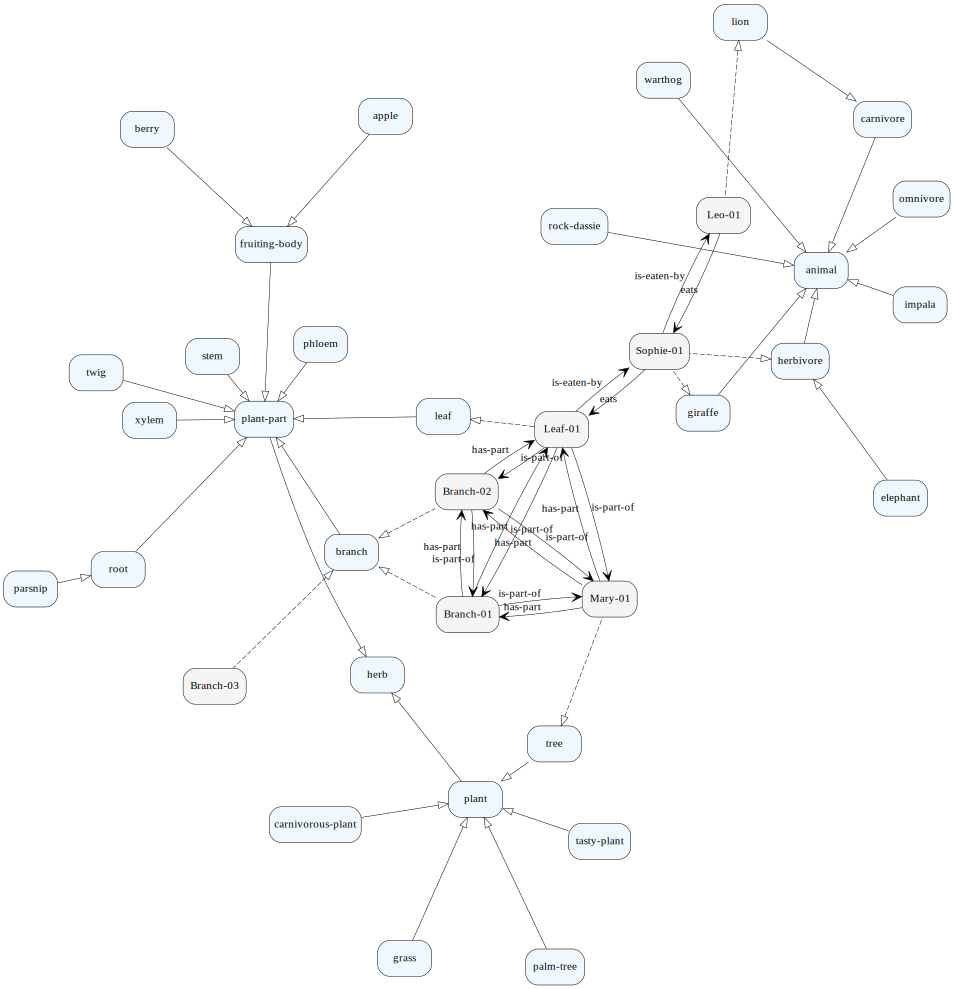

In [17]:
onto.draw_graph(layout="force directed")

In [18]:
q1_edit = CnlQueryForConcept('query_01.encnl',onto=onto)
q1_edit

In [19]:
onto.select_instances_of(q1_edit.getvalue())

,Instance,is-eaten-by,eats
0,Sophie-01,Leo-01,Leaf-01


In [20]:
print(onto.why("Leo-01 is an animal?"))

{"concluded":"Leo-01 is an animal.","by":[
    {"expr":"Every lion is an animal."},
    {"expr":"Leo-01 is a lion."}]}




In [21]:
onto.sparql_query(CQL("""select ?a1 ?a2 {
                            ?a1 rdf:type <animal>. 
                            ?a2 rdf:type <animal>. 
                            ?a1 <eats> ?a2. 
                        }""","http://cognitum.eu/african_wildlife#"))

,a1,a2
0,Leo-01,Sophie-01


In [22]:
print(onto.as_rdf())

<?xml version = '1.0' encoding = 'UTF-8'?>
<rdf:RDF xmlns="http://cognitum.eu/african_wildlife#" xml:base="http://cognitum.eu/african_wildlife" xmlns:owl="http://www.w3.org/2002/07/owl#" xmlns:rdfs="http://www.w3.org/2000/01/rdf-schema#" xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#" xmlns:xsd="http://www.w3.org/2001/XMLSchema#">
  <owl:Ontology rdf:about="http://cognitum.eu/african_wildlife#" />
  <!-- 
    ///////////////////////////////////////////////////////////////////////////////////////
    //
    // Object Properties
    //
    ///////////////////////////////////////////////////////////////////////////////////////
     -->
  <!-- http://cognitum.eu/african_wildlife#eats -->
  <owl:ObjectProperty rdf:about="http://cognitum.eu/african_wildlife#eats">
    <owl:equivalentProperty>
      <rdf:Description>
        <owl:inverseOf rdf:resource="http://cognitum.eu/african_wildlife#isEatenBy" />
      </rdf:Description>
    </owl:equivalentProperty>
  </owl:ObjectProperty>
  <!